<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-Projects/blob/main/Weather%20Prediction%20-%20Jena%20Climate%20Dataset%20(GRU%20Model)/Jena_Climate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [9]:
# Downloading Dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mnassrib/jena-climate")
print("Path to dataset files:", PATH)

Path to dataset files: /kaggle/input/jena-climate/jena_climate_2009_2016.csv


# Define Predictor

In [23]:
class TemperaturePredictor:
    def __init__(self, data_path, sequence_length=24):
        self.data_path = data_path
        self.sequence_length = sequence_length
        self.scaler = MinMaxScaler()
        self.model = None
        self.feature_columns = ['T (degC)', 'p (mbar)', 'rh (%)', 'wv (m/s)', 'wd (deg)']

    def load_and_preprocess_data(self):
        # df = pd.read_csv(self.data_path, parse_dates=['Date Time'])
        df = pd.read_csv(self.data_path, parse_dates=['Date Time'], dayfirst=True)

        df['Date Time'] = pd.to_datetime(df['Date Time'])
        df = df.set_index("Date Time")
        df = df[self.feature_columns]
        df = df.resample('1H').mean().interpolate() # Resample & Interpolate missing values

        # Add time based features
        df['hour'] = df.index.hour
        df['day'] = df.index.dayofweek
        df['month'] = df.index.month
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['day_sin'] = np.sin(2 * np.pi * df['day'] / 7)
        df['day_cos'] = np.cos(2 * np.pi * df['day'] / 7)
        df.drop(['hour', 'day', 'month'], axis=1, inplace=True)

        # Normalization
        scaled = self.scaler.fit_transform(df)

        X, y = [], []
        for i in range(len(scaled) - self.sequence_length):
            X.append(scaled[i: i + self.sequence_length])
            y.append(scaled[i + self.sequence_length][0])
        X, y = np.array(X), np.array(y)

        # Split
        split = int(0.8 * len(X))
        return X[:split], y[:split], X[split:], y[split:]

    def build_model(self):
        self.model = Sequential([
            GRU(128, return_sequences=False, input_shape=(self.sequence_length, len(self.feature_columns) + 4)),
            Dense(64, activation='relu'),
            Dense(1)
        ])
        self.model.compile(optimizer='adam', loss='mse')

    def train(self, X_train, y_train):
        # Define early stop
        early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        self.model.fit(X_train, y_train,
                       epochs=10,
                       batch_size=32,
                       callbacks=[early_stop])

    def evaluate(self, X_test, y_test):
        predictions = self.model.predict(X_test)
        y_test_inv = self.scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1),
                                                              np.zeros((len(y_test), X_test.shape[2] - 1)))))[:, 0]
        pred_inv = self.scaler.inverse_transform(np.hstack((predictions,
                                                            np.zeros((len(predictions), X_test.shape[2] - 1)))))[:, 0]

        rmse = np.sqrt(mean_squared_error(y_test_inv, pred_inv))

        print(f"Test RMSE: {rmse:.2f}")
        return y_test_inv, pred_inv

    def plot_results(self, y_true, y_pred):
        plt.figure(figsize=(10, 4))
        plt.plot(y_true, label='True Temp')
        plt.plot(y_pred, label='Predicted Temp')
        plt.title('GRU Temperature Forecast')
        plt.xlabel('Time')
        plt.ylabel('Temperature (°C)')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


Epoch 1/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 50s 27ms/step - loss: 0.0065
Epoch 2/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 81s 27ms/step - loss: 1.9446e-04
Epoch 3/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 84s 28ms/step - loss: 1.6506e-04
Epoch 4/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 80s 27ms/step - loss: 1.5467e-04
Epoch 5/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 48s 27ms/step - loss: 1.4598e-04
Epoch 6/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 48s 27ms/step - loss: 1.3228e-04
Epoch 7/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 80s 26ms/step - loss: 1.1870e-04
Epoch 8/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 83s 27ms/step - loss: 1.1942e-04
Epoch 9/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 48s 27ms/step - loss: 1.1680e-04
Epoch 10/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 81s 27ms/step - loss: 1.1671e-04
439/439 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Test RMSE: 0.60C


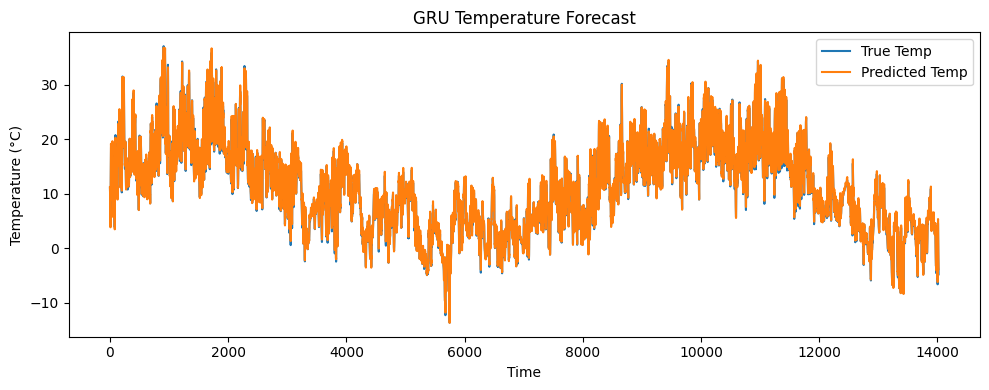

In [24]:
DATA_PATH = '/kaggle/input/jena-climate/jena_climate_2009_2016.csv'
# Define predictor
predictor = TemperaturePredictor(data_path = DATA_PATH)
# Split Train/Test
X_train, y_train, X_test, y_test = predictor.load_and_preprocess_data()
# Build model
predictor.build_model()
# Train Model
predictor.train(X_train, y_train)
# Evaluate model
y_true, y_pred = predictor.evaluate(X_test, y_test)
# Plot results
predictor.plot_results(y_true, y_pred)